In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [12]:
# !pip install -U optuna
# !pip install optuna-integration
# !pip install 'u8darts[all]'

In [56]:
import warnings
warnings.filterwarnings(
    "ignore"
)

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import logging
logging.disable(logging.CRITICAL)



# data processing
from darts import concatenate
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
import datetime
import importlib
import json
import numpy as np
import pandas as pd
import random
import sys
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# modeling
from darts.models import (BlockRNNModel, ExponentialSmoothing, LightGBMModel, NBEATSModel,
                          NHiTSModel, RandomForest, RegressionEnsembleModel, XGBModel)
from darts.models.forecasting.baselines import NaiveSeasonal
from darts.models.forecasting.torch_forecasting_model import _get_checkpoint_folder
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.utils.utils import ModelMode, SeasonalityMode
import optuna
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping,  ModelCheckpoint
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import torch

# metrics
from darts.metrics import mae, r2_score, rmse
# from torchmetrics import MeanAbsoluteError, MeanSquaredError, MetricCollection


In [14]:
sys.path.append('/content/gdrive/My Drive')
from project_code import processing_functions as pf

file_path_data = 'gdrive/MyDrive/MRP/data/'
file_path_results = 'gdrive/MyDrive/MRP/results/'
file_path_models = 'gdrive/MyDrive/MRP/models/'
file_name_o = 'weather_bbm_incl_outliers.csv'
file_name_no = 'weather_bbm_clean.csv'

file_hyperparams = 'gdrive/MyDrive/MRP/models/hyperparam_optmz_results2.json'

# read in the data
weather_data_outliers = pd.read_csv(f'{file_path_data}{file_name_o}',
                   index_col='date')

weather_data_clean = pd.read_csv(f'{file_path_data}{file_name_no}',
                   index_col='date')


# retrieve optimized hyperparameters
hyper_params = pf.read_json_file(file_hyperparams, output_type='dict')

nbeats_hyp = hyper_params['nbeats']['best_parameters']
nhits_hyp = hyper_params['nhits']['best_parameters']
lstm_hyp = hyper_params['lstm']['best_parameters']
gru_hyp = hyper_params['gru']['best_parameters']
rf_hyp = hyper_params['random_forest']['best_parameters']
xgb_hyp = hyper_params['xgboost']['best_parameters']
lgbm_hyp = hyper_params['light_gbm']['best_parameters']


In [15]:
FORECAST_HORIZON = 30

MODEL_NAMES = {
    'naive_seasonal': 'Naive Seasonal',
    'exponential_smoothing': 'Exponential Smoothing',
    'random_forest': 'Random Forest',
    'xgboost': 'XGBoost',
    'lightgbm': 'LightGBM',
    'lstm': 'LSTM',
    'gru': 'GRU',
    'nbeats': 'N-BEATS',
    'nhits': 'N-HiTS',
}

# isolate the required parameters
nbeats_hyp = hyper_params['nbeats']['best_parameters']
nhits_hyp = hyper_params['nhits']['best_parameters']
lstm_hyp = hyper_params['lstm']['best_parameters']
gru_hyp = hyper_params['gru']['best_parameters']
rf_hyp = hyper_params['random_forest']['best_parameters']
xgb_hyp = hyper_params['xgboost']['best_parameters']
lgbm_hyp = hyper_params['light_gbm']['best_parameters']


In [15]:

def generate_random_date(start, end, n=1, seed=1, replace=False):
    """Generates a random date from a given range (start to end) for the training cutoff."""
    dates = pd.date_range(start, end).to_series()

    dates = dates.sample(n, replace=replace, random_state=seed)

    date = dates[0].strftime('%Y-%m-%d')

    year, month, day = [int(x) for x in date.split('-')]

    return year, month, day


def get_model(model_name):

    """Returns an unfitted model based on the given name and hyperparameters."""

    if model_name in ['lstm', 'gru', 'nbeats', 'nhits']:

        torch.manual_seed(1)

        checkpoint_name = f'{model_name}_ckpt'

        checkpoint_callback = ModelCheckpoint(
            monitor='train_torchmetrics',
            filename='best-{epoch}-{MeanAbsoluteError:.2f}',
            dirpath= _get_checkpoint_folder(
                work_dir = os.path.join(os.getcwd(), "darts_logs"),
                model_name = model_name,
            )
        )

        # detect whether a GPU is available
        print(f'Available GPU: {torch.cuda.is_available()}\n')
        if torch.cuda.is_available():
            pl_trainer_kwargs = {
                'accelerator': 'gpu',
                'callbacks': [checkpoint_callback],
            }
        else:
            pl_trainer_kwargs = {'callbacks': [checkpoint_callback]}


        if model_name == 'lstm':
            model = BlockRNNModel(
                model='LSTM',
                input_chunk_length = lstm_hyp['input_chunk_length'],
                output_chunk_length = FORECAST_HORIZON,
                batch_size = lstm_hyp['batch_size'],
                n_epochs = lstm_hyp['n_epochs'],
                hidden_dim = lstm_hyp['hidden_dim'],
                n_rnn_layers = lstm_hyp['n_rnn_layers'],
                dropout = lstm_hyp['dropout'],
                pl_trainer_kwargs = pl_trainer_kwargs,
                optimizer_kwargs = {'lr': lstm_hyp['lr'] },
                log_tensorboard=True,
                model_name = model_name,
                save_checkpoints=True,
                force_reset=True,

            )

        elif model_name == 'gru':
            model = BlockRNNModel(
                model='GRU',
                input_chunk_length = gru_hyp['input_chunk_length'],
                output_chunk_length = FORECAST_HORIZON,
                batch_size = gru_hyp['batch_size'],
                n_epochs = gru_hyp['n_epochs'],
                hidden_dim = gru_hyp['hidden_dim'],
                n_rnn_layers = gru_hyp['n_rnn_layers'],
                # dropout = gru_hyp['dropout'], # results were worse w/ dropout during hyperparam optimization
                pl_trainer_kwargs = pl_trainer_kwargs,
                optimizer_kwargs = {'lr': gru_hyp['lr'] },
                log_tensorboard=True,
                model_name = model_name,
                save_checkpoints=True,
                force_reset=True,
            )

        elif model_name == 'nbeats':
            model = NBEATSModel(
                random_state=1,
                input_chunk_length = nbeats_hyp['input_chunk_length'],
                output_chunk_length = FORECAST_HORIZON,
                batch_size = nbeats_hyp['batch_size'],
                n_epochs = nbeats_hyp['n_epochs'],
                num_blocks = nbeats_hyp['num_blocks'],
                num_layers = nbeats_hyp['num_layers'],
                dropout = nbeats_hyp['dropout'],
                activation =  nbeats_hyp['activation'],
                generic_architecture=False,
                # torch_metrics=TORCH_METRICS,
                pl_trainer_kwargs = pl_trainer_kwargs,
                optimizer_kwargs = {'lr': nbeats_hyp['lr'] },
                log_tensorboard=True,
                model_name = model_name,
                save_checkpoints=True,
                force_reset=True,

            )


        elif model_name == 'nhits':
            model = NHiTSModel(
                input_chunk_length = nhits_hyp['input_chunk_length'],
                output_chunk_length = FORECAST_HORIZON,
                batch_size = nhits_hyp['batch_size'],
                n_epochs = nhits_hyp['n_epochs'],
                num_blocks = nhits_hyp['num_blocks'],
                num_layers = nhits_hyp['num_layers'],
                dropout = nhits_hyp['dropout'],
                activation =  nhits_hyp['activation'],
                # torch_metrics=TORCH_METRICS,
                pl_trainer_kwargs = pl_trainer_kwargs,
                optimizer_kwargs = {'lr': nhits_hyp['lr'] },
                log_tensorboard=True,
                model_name = model_name,
                save_checkpoints=True,
                force_reset=True,
            )


    else:

        if model_name == 'naive_seasonal':
            model = NaiveSeasonal(K=365)

        elif model_name == 'exponential_smoothing':
            model = ExponentialSmoothing(trend=ModelMode.ADDITIVE,
                                    seasonal=SeasonalityMode.ADDITIVE,
                                    seasonal_periods=365)

        elif model_name == 'random_forest':
            model = RandomForest(
                lags = rf_hyp['lags'],
                lags_past_covariates = rf_hyp['lags_past_covariates'],
                n_estimators = rf_hyp['n_estimators'],
                max_depth = rf_hyp['max_depth'],
                output_chunk_length = FORECAST_HORIZON
            )

        elif model_name == 'xgboost':
            model = XGBModel(
                lags = xgb_hyp['lags'],
                lags_past_covariates = xgb_hyp['lags_past_covariates'],
                output_chunk_length = FORECAST_HORIZON
            )

        elif model_name == 'lightgbm':
            model = LightGBMModel(
                lags = lgbm_hyp['lags'],
                lags_past_covariates = lgbm_hyp['lags_past_covariates'],
                output_chunk_length = FORECAST_HORIZON,
                verbose=-1
            )

    return model


def train_test_split(cutoff, outliers=False):

    cutoff_date = f'{cutoff[0]}-{cutoff[1]}-{cutoff[2]}'

    if outliers==False:

        target = pf.create_timeseries(weather_data_clean, 'sunshine_hr')

        # create past covariates as stacked timeseries of exogenous variables
        past_covariates = pf.get_covariate_ts(weather_data_clean)

        # create training and testing datasets
        training_cutoff = pd.Timestamp(cutoff_date)

        target_train, target_test = target.split_after(training_cutoff)
        covariates_train, covariates_test = past_covariates.split_after(training_cutoff)

        covariate_scaler = Scaler()
        covariate_scaler.fit(covariates_train)
        past_covariates_trf = covariate_scaler.transform(past_covariates)

    elif outliers == True:

        target = pf.create_timeseries(weather_data_outliers, 'sunshine_hr')

        # create past covariates as stacked timeseries of exogenous variables
        past_covariates = pf.get_covariate_ts(weather_data_outliers)

        # create training and testing datasets
        training_cutoff = pd.Timestamp(cutoff_date)

        target_train, target_test = target.split_after(training_cutoff)
        covariates_train, covariates_test = past_covariates.split_after(training_cutoff)

        covariate_scaler = Scaler()
        covariate_scaler.fit(covariates_train)
        past_covariates_trf = covariate_scaler.transform(past_covariates)


    return target_train, target_test, past_covariates_trf


def run_test(model,
             model_name,
             outliers,
             test_year,
             date_seed):

    proper_name = MODEL_NAMES[model_name]

    print(f'\nRunning {proper_name} Test - Outliers = {outliers}...\n')

    start_time = time.perf_counter()

    if model_name in ['naive_seasonal', 'exponential_smoothing']:
        model.fit(series=target_train)

    else:
        model.fit(series=target_train,
        past_covariates=past_covariates_trf)

    end_time = time.perf_counter()
    training_time = (end_time - start_time) / 60


    model.save(f'{model_name}_fitted.pt')
    y_pred = model.predict(n=FORECAST_HORIZON)

    # Record results
    names = [MODEL_NAMES[model_name]] * FORECAST_HORIZON
    outlier_indicator = [outliers] * FORECAST_HORIZON
    forecast_horizon = [x for x in range(1,FORECAST_HORIZON+1)]
    rmse_scores = np.zeros(FORECAST_HORIZON)
    mae_scores = np.zeros(FORECAST_HORIZON)


    for fh in range(FORECAST_HORIZON):
        rmse_score = rmse(y_pred[:fh+1], target_test[:fh+1])
        mae_score = mae(y_pred[:fh+1], target_test[:fh+1])
        rmse_scores[fh] = rmse_score
        mae_scores[fh] = rmse_score # ERROR - NEED TO CORRECT TO mae_score

    df_training = pd.DataFrame({
        'model_name': [proper_name],
        'training_time': [training_time],
        'outlier_indicator': [outliers]
    })

    df_errors = pd.DataFrame({
        'model_name' :  names,
        'outlier_indicator': outlier_indicator,
        'forecast_horizon': forecast_horizon,
        'actual_sd': target_test[:FORECAST_HORIZON].pd_series().tolist(),
        'predicted_sd': y_pred.pd_series().tolist(),
        'rmse': rmse_scores,
        'mae': mae_scores,
    })

    return df_training, df_errors





# Experiments

In [16]:
TEST_YEAR = 2023
SEED=0

df_train_time_all = pd.DataFrame(columns=['model_name', 'training_time', 'outlier_indicator'])
df_errors_all = pd.DataFrame(columns=['model_name', 'outlier_indicator', 'forecast_horizon',
                                      'actual_sd', 'predicted_sd', 'rmse', 'mae'])


year, month, day = generate_random_date(start=f'{TEST_YEAR}0101', end=f'{TEST_YEAR}1130', n=1, seed=SEED)


print(f'Selected Training cut-off date: {year}-{month}-{day}')

start_time = time.perf_counter()

for name in MODEL_NAMES.keys():
    model = get_model(name)

    for outlier_arg in [True, False]:

        target_train, target_test, past_covariates_trf = train_test_split(cutoff=[year, month, day], outliers=outlier_arg)

        df_train_time, df_errors = run_test(model,
                model_name=name,
                outliers=outlier_arg,
                test_year=TEST_YEAR,
                date_seed=SEED)


        df_errors_all = pd.concat([df_errors_all, df_errors],axis=0)
        df_train_time_all = pd.concat([df_train_time_all, df_train_time], axis=0)

        # save results
        df_errors_all.to_csv(f'{file_path_results}/experiments_errors.csv')
        df_train_time_all.to_csv(f'{file_path_results}/experiments_train_time.csv')

end_time = time.perf_counter()
total_experiment_time = (end_time - start_time) / 60

print(f'\nExperiments Completed in {total_experiment_time:.2f} minutes ({total_experiment_time/60:.2f} hours).')



Selected Training cut-off date: 2023-6-16

Running Naive Seasonal Test - Outliers = True...


Running Naive Seasonal Test - Outliers = False...


Running Exponential Smoothing Test - Outliers = True...


Running Exponential Smoothing Test - Outliers = False...



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



Running Random Forest Test - Outliers = True...


Running Random Forest Test - Outliers = False...


Running XGBoost Test - Outliers = True...


Running XGBoost Test - Outliers = False...


Running LightGBM Test - Outliers = True...


Running LightGBM Test - Outliers = False...

Available GPU: True


Running LSTM Test - Outliers = True...



Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


Running LSTM Test - Outliers = False...



Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Available GPU: True


Running GRU Test - Outliers = True...



Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


Running GRU Test - Outliers = False...



Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Available GPU: True


Running N-BEATS Test - Outliers = True...



Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


Running N-BEATS Test - Outliers = False...



Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Available GPU: True


Running N-HiTS Test - Outliers = True...



Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


Running N-HiTS Test - Outliers = False...



Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


Experiments Completed in 200.42 minutes (3.34 hours).


In [17]:
df_errors_all

,model_name,outlier_indicator,forecast_horizon,actual_sd,predicted_sd,rmse,mae
0,Naive Seasonal,True,1,11.145781,6.544767,4.601014,4.601014
1,Naive Seasonal,True,2,10.068842,9.251800,3.304307,3.304307
2,Naive Seasonal,True,3,9.298330,10.598686,2.800465,2.800465
3,Naive Seasonal,True,4,9.234211,11.143887,2.606467,2.606467
4,Naive Seasonal,True,5,10.985447,11.112330,2.331985,2.331985
...,...,...,...,...,...,...,...
25,N-HiTS,False,26,11.077000,NaN,NaN,NaN
26,N-HiTS,False,27,11.048000,NaN,NaN,NaN
27,N-HiTS,False,28,11.018125,NaN,NaN,NaN
28,N-HiTS,False,29,11.018125,NaN,NaN,NaN


In [18]:
df_train_time_all

,model_name,training_time,outlier_indicator
0,Naive Seasonal,0.000003,True
0,Naive Seasonal,0.000005,False
0,Exponential Smoothing,0.273733,True
0,Exponential Smoothing,0.299453,False
0,Random Forest,0.778273,True
0,Random Forest,0.769309,False
0,XGBoost,0.233000,True
0,XGBoost,0.228241,False
0,LightGBM,0.073889,True
0,LightGBM,0.091132,False


## GPU Details

In [19]:
!nvidia-smi

Fri Sep 27 07:04:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              26W /  70W |    143MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

We notice and investigate the unexpected NA values

In [41]:
df_errors_all.loc[(df_errors_all['predicted_sd'].isna())].head(10)

,model_name,outlier_indicator,forecast_horizon,actual_sd,predicted_sd,rmse,mae
0,N-HiTS,False,1,11.14600,NaN,NaN,NaN
1,N-HiTS,False,2,11.09225,NaN,NaN,NaN
2,N-HiTS,False,3,11.09225,NaN,NaN,NaN
3,N-HiTS,False,4,11.09225,NaN,NaN,NaN
4,N-HiTS,False,5,11.09225,NaN,NaN,NaN
5,N-HiTS,False,6,11.09225,NaN,NaN,NaN
6,N-HiTS,False,7,11.09225,NaN,NaN,NaN
7,N-HiTS,False,8,11.09225,NaN,NaN,NaN
8,N-HiTS,False,9,11.09225,NaN,NaN,NaN
9,N-HiTS,False,10,11.09225,NaN,NaN,NaN


Having ascertained that they are all based on the N-HiTS model, we check the N-HiTS results with the outliers dataset to see if there is usable information.


In [19]:
train_time_file = f'{file_path_results}/experiments_train_time.csv'
errors_file = f'{file_path_results}/experiments_errors.csv'


df_errors_all = pd.read_csv(errors_file, index_col=0)
df_train_time_all = pd.read_csv(train_time_file, index_col=0)

df_errors_all.loc[(df_errors_all['model_name'] == 'N-HiTS') & (df_errors_all['outlier_indicator'] == True)].head()

,model_name,outlier_indicator,forecast_horizon,actual_sd,predicted_sd,rmse,mae
0,N-HiTS,True,1,11.145781,5.986586e+11,5.986586e+11,5.986586e+11
1,N-HiTS,True,2,10.068842,7.528972e+11,6.801641e+11,6.801641e+11
2,N-HiTS,True,3,9.298330,4.882251e+11,6.227921e+11,6.227921e+11
3,N-HiTS,True,4,9.234211,9.660387e+11,7.240236e+11,7.240236e+11
4,N-HiTS,True,5,10.985447,-6.361123e+11,7.073160e+11,7.073160e+11


Based on these values, we will exclude N-HiTS from our analysis.

In [20]:
errors = df_errors_all.loc[df_errors_all['model_name'] != 'N-HiTS']
training_time = df_train_time_all.loc[df_train_time_all['model_name'] != 'N-HiTS']

errors.head()

,model_name,outlier_indicator,forecast_horizon,actual_sd,predicted_sd,rmse,mae
0,Naive Seasonal,True,1,11.145781,6.544767,4.601014,4.601014
1,Naive Seasonal,True,2,10.068842,9.251800,3.304307,3.304307
2,Naive Seasonal,True,3,9.298330,10.598686,2.800465,2.800465
3,Naive Seasonal,True,4,9.234211,11.143887,2.606467,2.606467
4,Naive Seasonal,True,5,10.985447,11.112330,2.331985,2.331985


In [21]:
# subset performance based on outlier indicator
performance_o = errors.loc[errors['outlier_indicator'] == True]
performance_of = errors.loc[errors['outlier_indicator'] == False]

training_time_o = training_time.loc[training_time['outlier_indicator'] == True]
training_time_of = training_time.loc[training_time['outlier_indicator'] == False]


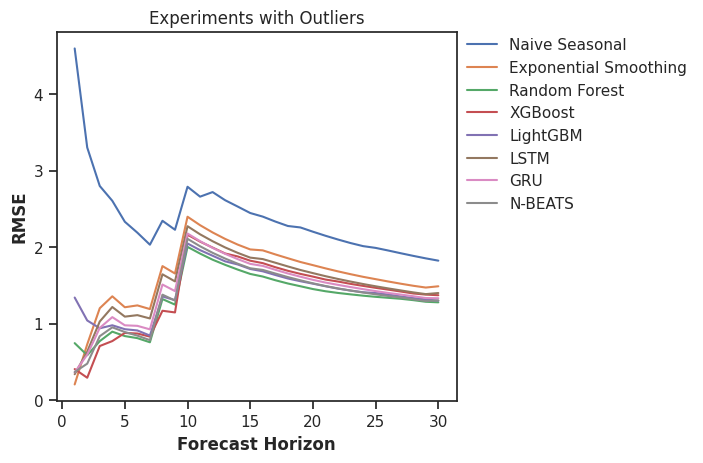

In [63]:
sns.set_theme(style='ticks')

g = sns.lineplot(data=performance_o, x='forecast_horizon', y='rmse', hue='model_name')

plt.subplots_adjust(right=0.75)
g.legend(bbox_to_anchor=(1.01,1), loc='upper left', borderaxespad=0)
g.set(xlabel='Forecast Horizon', ylabel='RMSE')
g.set_title('Experiments with Outliers')
plt.show()

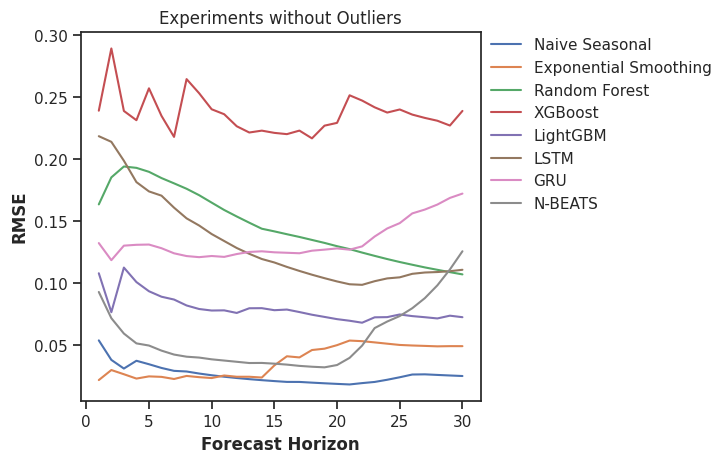

In [64]:
sns.set_theme(style='ticks')
# sns.set(font_scale=0.85)
g = sns.lineplot(data=performance_of, x='forecast_horizon', y='rmse', hue='model_name')
plt.subplots_adjust(right=0.75)
g.legend(bbox_to_anchor=(1.01,1), loc='upper left', borderaxespad=0)
g.set(xlabel='Forecast Horizon', ylabel='RMSE')
g.set_title('Experiments without Outliers')
plt.show()

In [32]:
mean_errors_of =  performance_of.groupby('model_name').mean()[['rmse', 'mae']].reset_index().sort_values(by='rmse')
mean_errors_o = performance_o.groupby('model_name').mean()[['rmse', 'mae']].reset_index().sort_values(by='rmse')

In [120]:
# avg_training_time = training_time.groupby('model_name').mean()['training_time'].reset_index()
# avg_training_time

# pd.merge(mean_errors_o)

In [33]:
# get the hyperparameter search times
names = ['Naive Seasonal', 'Exponential Smoothing']
hyperparam_search_time = [0, 0]


for m_name, results in hyper_params.items():
    if m_name == 'light_gbm':
        m_name = 'lightgbm'
    names.append(MODEL_NAMES[m_name])
    hyp_st = results['hyperparam_search_time']
    hyperparam_search_time.append(hyp_st)


df_hyp_search_time = pd.DataFrame({
    'model_name': names,
    'hyperparam_search_time': hyperparam_search_time
})


agg_df_o = df_hyp_search_time.merge(training_time_o, how='inner', on='model_name').merge(mean_errors_o, how='inner', on='model_name')
agg_df_of = df_hyp_search_time.merge(training_time_of, how='inner', on='model_name').merge(mean_errors_of, how='inner', on='model_name')
# agg_df_all =  pd.concat([agg_df_o, agg_df_of])

# agg_df_all

In [154]:
def dual_bar_chart(df, x,
                   y1, y2,
                   y1_label, y2_label,
                   y1_col, y2_col):

    """Plots a dual y-axis grouped bar chart. """
    fig = make_subplots(specs=[[{"secondary_y": True}]])



    fig.add_trace(go.Bar(x=df[x], y=df[y1], name=y1_label,
                        marker_color = y1_col,offsetgroup=1 ,), secondary_y=False)

    fig.add_trace(go.Bar(x=df[x], y=df[y2], name=y2_label,
                        marker_color = y2_col,offsetgroup=2 ,), secondary_y=True)

    fig.update_layout(
        barmode='group',
        font_size = 16,
        hovermode="x unified",
        plot_bgcolor='white'
        )

    fig.update_xaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey'
    )

    fig.update_yaxes(
    # mirror=True,
    ticks='outside',
    showline=True,
    # linecolor='black',
    gridcolor='lightgrey'
    )

    fig.update_yaxes(title_text=y2_label, secondary_y=True)
    fig.update_yaxes(title_text=y1_label, secondary_y=False)

    fig.show()

df = agg_df_of
x = 'model_name'
y1 = 'training_time'
y2 = 'rmse'
y1_label = 'Training Time (mins)'
y2_label = 'RMSE'
y1_col = '#00A3E0'
y2_col = 'orange'


dual_bar_chart(df, x,
                   y1, y2,
                   y1_label, y2_label,
                   y1_col='#00A3E0', y2_col='orange')


In [153]:
df = agg_df_o
x = 'model_name'
y1 = 'training_time'
y2 = 'rmse'
y1_label = 'Training Time (mins)'
y2_label = 'RMSE'
y1_col = '#00A3E0'
y2_col = 'orange'


dual_bar_chart(df, x,
                   y1, y2,
                   y1_label, y2_label,
                   y1_col='#00A3E0', y2_col='orange')
